In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Add, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# training and testing datasets
train_path = "/kaggle/input/spliteddataset/DATASET(Test Train)/Train"
test_path = "/kaggle/input/spliteddataset/DATASET(Test Train)/Test"

In [3]:
# image dimensions 
img_width, img_height = 224, 224

In [4]:
# batch size and number of epochs for training
batch_size = 22
epochs = 10

In [5]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 14259 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 6111 images belonging to 2 classes.


In [8]:
def train_model(model, model_name):
    print(f"Training {model_name}...")
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        verbose=1
    )
    
    return model, history

In [9]:
# Strategy 1: Freeze all layers except the custom head
def transfer_strategy_freeze(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    custom_head = base_model.output
    custom_head = GlobalAveragePooling2D()(custom_head)
    custom_head = Dense(128, activation='relu')(custom_head)
    custom_head = Dropout(0.5)(custom_head)
    custom_head = BatchNormalization()(custom_head)
    predictions = Dense(1, activation='sigmoid')(custom_head)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Strategy 2: Fine-tune some of the lower layers
def transfer_strategy_finetune(base_model, num_layers):
    for layer in base_model.layers[:-num_layers]:
        layer.trainable = False
    for layer in base_model.layers[-num_layers:]:
        layer.trainable = True

    custom_head = base_model.output
    custom_head = GlobalAveragePooling2D()(custom_head)
    custom_head = Dense(128, activation='relu')(custom_head)
    custom_head = Dropout(0.5)(custom_head)
    custom_head = BatchNormalization()(custom_head)
    predictions = Dense(1, activation='sigmoid')(custom_head)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Strategy 3: No transfer learning, train from scratch
def transfer_strategy_train_from_scratch(base_model):
    custom_head = base_model.output
    custom_head = GlobalAveragePooling2D()(custom_head)
    custom_head = Dense(128, activation='relu')(custom_head)
    custom_head = Dropout(0.5)(custom_head)
    custom_head = BatchNormalization()(custom_head)
    predictions = Dense(1, activation='sigmoid')(custom_head)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [10]:
# ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

resnet_model_freeze = transfer_strategy_freeze(resnet_base)
resnet_model_freeze.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model_freeze, resnet_history_freeze = train_model(resnet_model_freeze, "ResNet50 - Freeze")

resnet_model_finetune = transfer_strategy_finetune(resnet_base, num_layers=30)  # Experiment with the number of layers
resnet_model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model_finetune, resnet_history_finetune = train_model(resnet_model_finetune, "ResNet50 - Fine-tune")

resnet_model_scratch = transfer_strategy_train_from_scratch(resnet_base)
resnet_model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model_scratch, resnet_history_scratch = train_model(resnet_model_scratch, "ResNet50 - Train from Scratch")


94765736/94765736 [==============================] - 1s 0us/step
Training ResNet50 - Freeze...
Epoch 1/10
649/649 [==============================] - 251s 372ms/step - loss: 0.6218 - accuracy: 0.6807 - val_loss: 0.6221 - val_accuracy: 0.6868
Epoch 2/10
649/649 [==============================] - 185s 285ms/step - loss: 0.6225 - accuracy: 0.6868 - val_loss: 0.6208 - val_accuracy: 0.6868
Epoch 3/10
649/649 [==============================] - 182s 281ms/step - loss: 0.6223 - accuracy: 0.6868 - val_loss: 0.6206 - val_accuracy: 0.6868
Epoch 4/10
649/649 [==============================] - 182s 280ms/step - loss: 0.6211 - accuracy: 0.6868 - val_loss: 0.6220 - val_accuracy: 0.6868
Epoch 5/10
649/649 [==============================] - 182s 281ms/step - loss: 0.6221 - accuracy: 0.6868 - val_loss: 0.6217 - val_accuracy: 0.6868
Epoch 6/10
649/649 [==============================] - 181s 279ms/step - loss: 0.6225 - accuracy: 0.6868 - val_loss: 0.6217 - val_accuracy: 0.6868
Epoch 7/10
649/649 [=========

Evaluating models on test data:
Freeze Transfer Strategy:
278/278 [==============================] - 14s 50ms/step - loss: 7.7499 - accuracy: 0.3132
Loss: 7.7499, Accuracy: 0.3132
Fine-tune Transfer Strategy:
278/278 [==============================] - 13s 48ms/step - loss: 0.2222 - accuracy: 0.9429
Loss: 0.2222, Accuracy: 0.9429
Train from Scratch Transfer Strategy:
278/278 [==============================] - 14s 49ms/step - loss: 0.1593 - accuracy: 0.9727
Loss: 0.1593, Accuracy: 0.9727
1/1 [==============================] - 0s 324ms/step


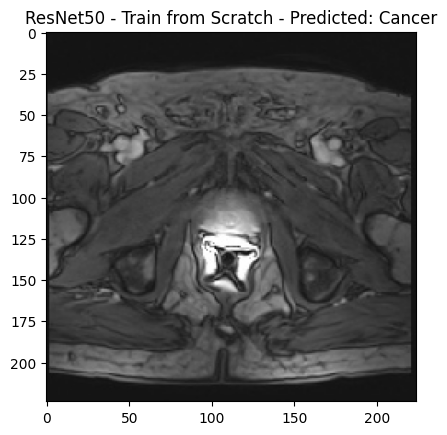

In [11]:
# Evaluate models on test data
print("Evaluating models on test data:")
print("Freeze Transfer Strategy:")
freeze_loss, freeze_accuracy = resnet_model_freeze.evaluate(test_generator)
print(f"Loss: {freeze_loss:.4f}, Accuracy: {freeze_accuracy:.4f}")

print("Fine-tune Transfer Strategy:")
finetune_loss, finetune_accuracy = resnet_model_finetune.evaluate(test_generator)
print(f"Loss: {finetune_loss:.4f}, Accuracy: {finetune_accuracy:.4f}")

print("Train from Scratch Transfer Strategy:")
scratch_loss, scratch_accuracy = resnet_model_scratch.evaluate(test_generator)
print(f"Loss: {scratch_loss:.4f}, Accuracy: {scratch_accuracy:.4f}")

# Print some example predictions
sample_images, sample_labels = next(test_generator)
sample_predictions_freeze = resnet_model_freeze.predict(sample_images)
sample_predictions_finetune = resnet_model_finetune.predict(sample_images)
sample_predictions_scratch = resnet_model_scratch.predict(sample_images)


# Visualize results 
def visualize_results(model, model_name):
    # Load an image for visualization
    image_path = os.path.join(test_path, "Significant Cancer", "Significant cancer10.jpg")
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, axis=0)

    # Get predictions
    prediction = model.predict(image)
    predicted_class = "Cancer" if prediction > 0.5 else "Healthy"

    plt.imshow(image[0]/255.0)
    plt.title(f"{model_name} - Predicted: {predicted_class}")
    plt.show()

visualize_results(resnet_model_scratch, "ResNet50 - Train from Scratch")

In [12]:
resnet_model_scratch.save("resnet_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


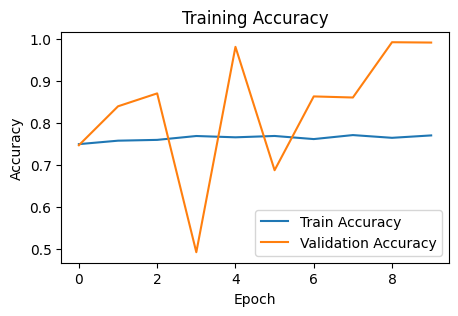

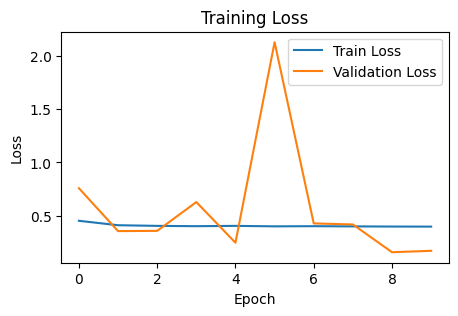

In [13]:
import matplotlib.pyplot as plt

# Training logs
training_logs = {
    'loss': [0.4543, 0.4129, 0.4068, 0.4039, 0.4068, 0.4024, 0.4039, 0.4020, 0.4005, 0.3998],
    'accuracy': [0.7501, 0.7583, 0.7602, 0.7694, 0.7663, 0.7695, 0.7621, 0.7716, 0.7651, 0.7708],
    'val_loss': [0.7593, 0.3579, 0.3601, 0.6295, 0.2491, 2.1250, 0.4297, 0.4200, 0.1603, 0.1735],
    'val_accuracy': [0.7475, 0.8400, 0.8707, 0.4932, 0.9813, 0.6881, 0.8635, 0.8609, 0.9923, 0.9915]
}

# Plot accuracy
plt.figure(figsize=(5,3))
plt.plot(training_logs['accuracy'], label='Train Accuracy')
plt.plot(training_logs['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(5,3))
plt.plot(training_logs['loss'], label='Train Loss')
plt.plot(training_logs['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

inception_model_freeze = transfer_strategy_freeze(inception_base)
inception_model_freeze.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
inception_model_freeze, inception_history_freeze = train_model(inception_model_freeze, "InceptionV3 - Freeze")

inception_model_finetune = transfer_strategy_finetune(inception_base, num_layers=50)  # Experiment with the number of layers
inception_model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
inception_model_finetune, inception_history_finetune = train_model(inception_model_finetune, "InceptionV3 - Fine-tune")

inception_model_scratch = transfer_strategy_train_from_scratch(inception_base)
inception_model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
inception_model_scratch, inception_history_scratch = train_model(inception_model_scratch, "InceptionV3 - Train from Scratch")


87910968/87910968 [==============================] - 0s 0us/step
Training InceptionV3 - Freeze...
Epoch 1/10
649/649 [==============================] - 188s 281ms/step - loss: 0.4473 - accuracy: 0.7474 - val_loss: 0.1996 - val_accuracy: 0.9468
Epoch 2/10
649/649 [==============================] - 177s 273ms/step - loss: 0.4147 - accuracy: 0.7498 - val_loss: 0.2434 - val_accuracy: 0.9696
Epoch 3/10
649/649 [==============================] - 178s 274ms/step - loss: 0.4078 - accuracy: 0.7579 - val_loss: 0.1893 - val_accuracy: 0.9555
Epoch 4/10
649/649 [==============================] - 182s 280ms/step - loss: 0.4006 - accuracy: 0.7621 - val_loss: 0.1776 - val_accuracy: 0.9681
Epoch 5/10
649/649 [==============================] - 181s 280ms/step - loss: 0.4065 - accuracy: 0.7582 - val_loss: 0.1751 - val_accuracy: 0.9761
Epoch 6/10
649/649 [==============================] - 180s 277ms/step - loss: 0.4052 - accuracy: 0.7616 - val_loss: 0.2116 - val_accuracy: 0.9542
Epoch 7/10
649/649 [======

Evaluating models on test data:
Freeze Transfer Strategy:
278/278 [==============================] - 14s 49ms/step - loss: 0.5563 - accuracy: 0.8177
Loss: 0.5563, Accuracy: 0.8177
Fine-tune Transfer Strategy:
278/278 [==============================] - 13s 48ms/step - loss: 0.2724 - accuracy: 0.8802
Loss: 0.2724, Accuracy: 0.8802
Train from Scratch Transfer Strategy:
278/278 [==============================] - 15s 52ms/step - loss: 0.3357 - accuracy: 0.8774
Loss: 0.3357, Accuracy: 0.8774
1/1 [==============================] - 1s 649ms/step


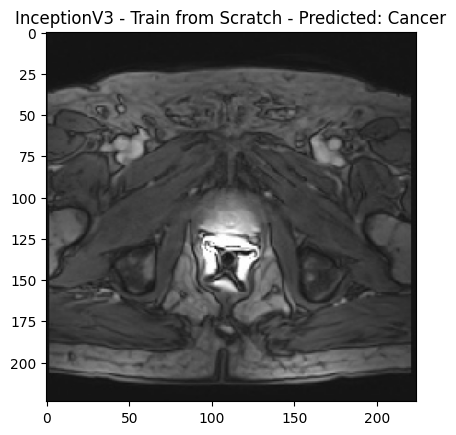

In [15]:
# Evaluate models on test data
print("Evaluating models on test data:")
print("Freeze Transfer Strategy:")
freeze_loss, freeze_accuracy = inception_model_freeze.evaluate(test_generator)
print(f"Loss: {freeze_loss:.4f}, Accuracy: {freeze_accuracy:.4f}")

print("Fine-tune Transfer Strategy:")
finetune_loss, finetune_accuracy = inception_model_finetune.evaluate(test_generator)
print(f"Loss: {finetune_loss:.4f}, Accuracy: {finetune_accuracy:.4f}")

print("Train from Scratch Transfer Strategy:")
scratch_loss, scratch_accuracy = inception_model_scratch.evaluate(test_generator)
print(f"Loss: {scratch_loss:.4f}, Accuracy: {scratch_accuracy:.4f}")

# Print some example predictions
sample_images, sample_labels = next(test_generator)
sample_predictions_freeze = inception_model_freeze.predict(sample_images)
sample_predictions_finetune = inception_model_finetune.predict(sample_images)
sample_predictions_scratch = inception_model_scratch.predict(sample_images)


# Visualize results 
def visualize_results(model, model_name):
    # Load an image for visualization
    image_path = os.path.join(test_path, "Significant Cancer", "Significant cancer10.jpg")
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, axis=0)

    # Get predictions
    prediction = model.predict(image)
    predicted_class = "Cancer" if prediction > 0.5 else "Healthy"

    plt.imshow(image[0]/255.0)
    plt.title(f"{model_name} - Predicted: {predicted_class}")
    plt.show()

visualize_results(inception_model_scratch, "InceptionV3 - Train from Scratch")

In [16]:
inception_model_scratch.save("inception_model.h5")

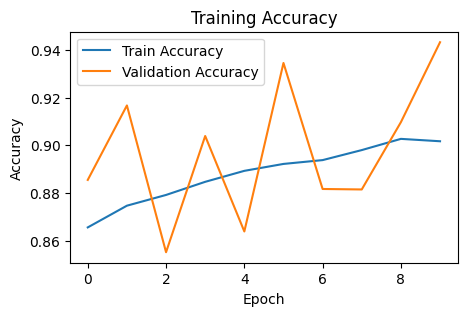

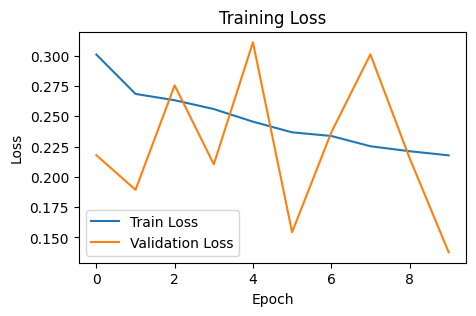

In [17]:
import matplotlib.pyplot as plt

# Training logs
training_logs = {
    'loss': [0.3010, 0.2685, 0.2633, 0.2560, 0.2456, 0.2368, 0.2338, 0.2253, 0.2212, 0.2178],
    'accuracy': [0.8656, 0.8747, 0.8792, 0.8847, 0.8893, 0.8922, 0.8938, 0.8980, 0.9027, 0.9017],
    'val_loss': [0.2179, 0.1893, 0.2756, 0.2104, 0.3112, 0.1543, 0.2366, 0.3012, 0.2157, 0.1378],
    'val_accuracy': [0.8855, 0.9167, 0.8552, 0.9039, 0.8639, 0.9345, 0.8817, 0.8815, 0.9097, 0.9432]
}


# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(training_logs['accuracy'], label='Train Accuracy')
plt.plot(training_logs['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(training_logs['loss'], label='Train Loss')
plt.plot(training_logs['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# DenseNet121
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

densenet_model_freeze = transfer_strategy_freeze(densenet_base)
densenet_model_freeze.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
densenet_model_freeze, densenet_history_freeze = train_model(densenet_model_freeze, "DenseNet121 - Freeze")

densenet_model_finetune = transfer_strategy_finetune(densenet_base, num_layers=100)  # Experiment with the number of layers
densenet_model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
densenet_model_finetune, densenet_history_finetune = train_model(densenet_model_finetune, "DenseNet121 - Fine-tune")

densenet_model_scratch = transfer_strategy_train_from_scratch(densenet_base)
densenet_model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
densenet_model_scratch, densenet_history_scratch = train_model(densenet_model_scratch, "DenseNet121 - Train from Scratch")

29084464/29084464 [==============================] - 0s 0us/step
Training DenseNet121 - Freeze...
Epoch 1/10
649/649 [==============================] - 199s 293ms/step - loss: 0.4384 - accuracy: 0.7556 - val_loss: 0.2180 - val_accuracy: 0.9002
Epoch 2/10
649/649 [==============================] - 181s 278ms/step - loss: 0.3979 - accuracy: 0.7708 - val_loss: 0.1906 - val_accuracy: 0.9326
Epoch 3/10
649/649 [==============================] - 180s 277ms/step - loss: 0.3945 - accuracy: 0.7707 - val_loss: 0.2049 - val_accuracy: 0.9151
Epoch 4/10
649/649 [==============================] - 189s 290ms/step - loss: 0.3979 - accuracy: 0.7675 - val_loss: 0.1583 - val_accuracy: 0.9651
Epoch 5/10
649/649 [==============================] - 186s 287ms/step - loss: 0.4163 - accuracy: 0.7504 - val_loss: 0.1704 - val_accuracy: 0.9763
Epoch 6/10
649/649 [==============================] - 182s 281ms/step - loss: 0.4241 - accuracy: 0.7405 - val_loss: 0.2061 - val_accuracy: 0.9277
Epoch 7/10
649/649 [======

In [19]:
densenet_model_scratch.save("densenet_model.h5")

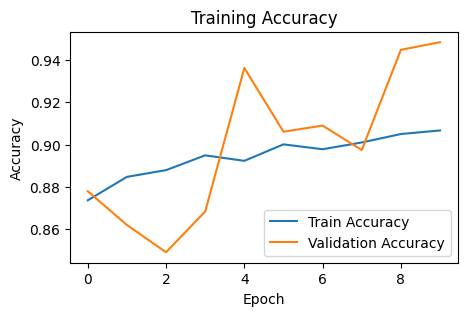

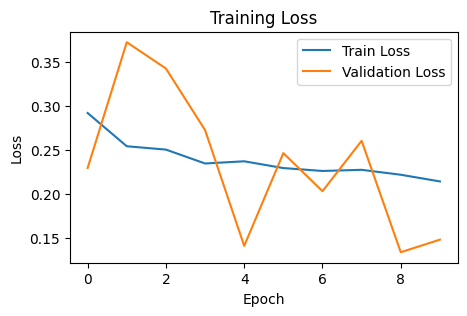

In [20]:
import matplotlib.pyplot as plt

# Training logs
training_logs = {
    'loss': [0.2922, 0.2544, 0.2506, 0.2348, 0.2373, 0.2296, 0.2263, 0.2276, 0.2220, 0.2144],
    'accuracy': [0.8736, 0.8847, 0.8879, 0.8949, 0.8923, 0.9001, 0.8978, 0.9010, 0.9050, 0.9067],
    'val_loss': [0.2297, 0.3727, 0.3428, 0.2728, 0.1411, 0.2466, 0.2033, 0.2606, 0.1339, 0.1482],
    'val_accuracy': [0.8779, 0.8619, 0.8490, 0.8683, 0.9363, 0.9061, 0.9090, 0.8974, 0.9449, 0.9485]
}


# Plot accuracy
plt.figure(figsize=(5,3))
plt.plot(training_logs['accuracy'], label='Train Accuracy')
plt.plot(training_logs['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(5,3))
plt.plot(training_logs['loss'], label='Train Loss')
plt.plot(training_logs['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Evaluating models on test data:
Freeze Transfer Strategy:
278/278 [==============================] - 14s 49ms/step - loss: 0.3214 - accuracy: 0.8035
Loss: 0.3214, Accuracy: 0.8035
Fine-tune Transfer Strategy:
278/278 [==============================] - 14s 50ms/step - loss: 0.1873 - accuracy: 0.8987
Loss: 0.1873, Accuracy: 0.8987
Train from Scratch Transfer Strategy:
278/278 [==============================] - 15s 53ms/step - loss: 0.1014 - accuracy: 0.9586
Loss: 0.1014, Accuracy: 0.9586
1/1 [==============================] - 1s 960ms/step


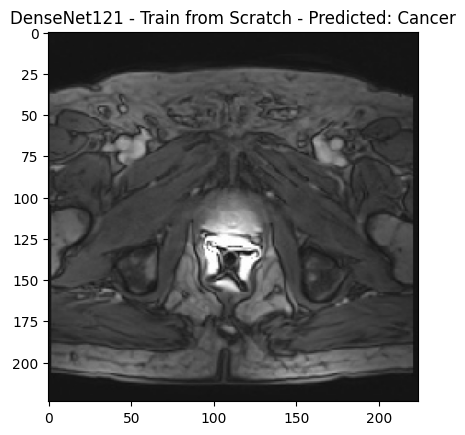

In [21]:
# Evaluate models on test data
print("Evaluating models on test data:")
print("Freeze Transfer Strategy:")
freeze_loss, freeze_accuracy = densenet_model_freeze.evaluate(test_generator)
print(f"Loss: {freeze_loss:.4f}, Accuracy: {freeze_accuracy:.4f}")

print("Fine-tune Transfer Strategy:")
finetune_loss, finetune_accuracy = densenet_model_finetune.evaluate(test_generator)
print(f"Loss: {finetune_loss:.4f}, Accuracy: {finetune_accuracy:.4f}")

print("Train from Scratch Transfer Strategy:")
scratch_loss, scratch_accuracy = densenet_model_scratch.evaluate(test_generator)
print(f"Loss: {scratch_loss:.4f}, Accuracy: {scratch_accuracy:.4f}")

# Print some example predictions
sample_images, sample_labels = next(test_generator)
sample_predictions_freeze = densenet_model_freeze.predict(sample_images)
sample_predictions_finetune = densenet_model_finetune.predict(sample_images)
sample_predictions_scratch = densenet_model_scratch.predict(sample_images)


# Visualize results 
def visualize_results(model, model_name):
    # Load an image for visualization
    image_path = os.path.join(test_path, "Significant Cancer", "Significant cancer10.jpg")
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, axis=0)

    # Get predictions
    prediction = model.predict(image)
    predicted_class = "Cancer" if prediction > 0.5 else "Healthy"

    plt.imshow(image[0]/255.0)
    plt.title(f"{model_name} - Predicted: {predicted_class}")
    plt.show()

visualize_results(densenet_model_scratch, "DenseNet121 - Train from Scratch")

In [22]:
# Define the train_model function
def train_model(model, model_name):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=len(test_generator)
    )
    return model, history

In [23]:
# Function to plot accuracy and loss graphs
def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [24]:
# Ensemble model prediction
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    return np.mean(predictions, axis=0)

In [25]:
# Create a list of trained models
models = [resnet_model_scratch, inception_model_scratch, densenet_model_scratch]


# Load and preprocess test data for ensemble
ensemble_test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 6111 images belonging to 2 classes.


In [26]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Create a list of trained models
models = [resnet_model_scratch, inception_model_scratch, densenet_model_scratch]

# Combine the models into an ensemble
input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3))
outputs = [model(input_layer) for model in models]
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

# Compile the ensemble model (you can adjust the optimizer and loss function as needed)
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate ensemble model
ensemble_predictions = ensemble_predict(models, ensemble_test_generator)
ensemble_accuracy = accuracy_score(ensemble_test_generator.labels, np.round(ensemble_predictions))
ensemble_loss = tf.keras.losses.binary_crossentropy(ensemble_test_generator.labels, ensemble_predictions).numpy().mean()
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Test Loss: {ensemble_loss:.4f}")

# Save the ensemble model as a .h5 file
ensemble_model.save("final_ensemble_model.h5")
print(f"Ensemble Model saved as ensemble_model.h5")


278/278 [==============================] - 17s 54ms/step
Ensemble Test Accuracy: 0.9429
Ensemble Test Loss: 1.6200


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ensemble Model saved as ensemble_model.h5


In [27]:
# Display individual predictions and ensemble prediction for a sample image
sample_image_path = os.path.join(test_path, "Significant Cancer", "Significant cancer100.jpg")
sample_image = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(img_width, img_height))
sample_image_array = tf.keras.preprocessing.image.img_to_array(sample_image) / 255.0

individual_predictions = []
for model in models:
    individual_predictions.append(model.predict(np.expand_dims(sample_image_array, axis=0))[0][0])

ensemble_prediction = np.mean(individual_predictions)

print("Individual Model Predictions:")
for idx, pred in enumerate(individual_predictions):
    print(f"Model {idx + 1}: Prediction = {pred:.4f}, Class = {'Cancer' if pred > 0.5 else 'Healthy'}")

print(f"Ensemble Prediction: {ensemble_prediction:.4f}, Class = {'Cancer' if ensemble_prediction > 0.5 else 'Healthy'}")

1/1 [==============================] - 0s 29ms/step
Individual Model Predictions:
Model 1: Prediction = 0.9995, Class = Cancer
Model 2: Prediction = 1.0000, Class = Cancer
Model 3: Prediction = 1.0000, Class = Cancer
Ensemble Prediction: 0.9998, Class = Cancer


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Create an input layer
input_layer = Input(shape=(img_width, img_height, 3))

# Pass the input through each individual model and average their outputs
individual_outputs = [model(input_layer) for model in models]
ensemble_output = tf.keras.layers.Average()(individual_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)


Epoch 1/10
649/649 [==============================] - 279s 370ms/step - loss: 0.2227 - accuracy: 0.9135 - val_loss: 0.1645 - val_accuracy: 0.9493
Epoch 2/10
649/649 [==============================] - 224s 345ms/step - loss: 0.2243 - accuracy: 0.9095 - val_loss: 0.2076 - val_accuracy: 0.9125
Epoch 3/10
649/649 [==============================] - 219s 337ms/step - loss: 0.2296 - accuracy: 0.9081 - val_loss: 0.1766 - val_accuracy: 0.9431
Epoch 4/10
649/649 [==============================] - 220s 339ms/step - loss: 0.2247 - accuracy: 0.9079 - val_loss: 0.2909 - val_accuracy: 0.8879
Epoch 5/10
649/649 [==============================] - 221s 340ms/step - loss: 0.2260 - accuracy: 0.9083 - val_loss: 0.2524 - val_accuracy: 0.9144
Epoch 6/10
649/649 [==============================] - 224s 344ms/step - loss: 0.2322 - accuracy: 0.9051 - val_loss: 0.1412 - val_accuracy: 0.9414
Epoch 7/10
649/649 [==============================] - 224s 345ms/step - loss: 0.2183 - accuracy: 0.9135 - val_loss: 0.3665 -

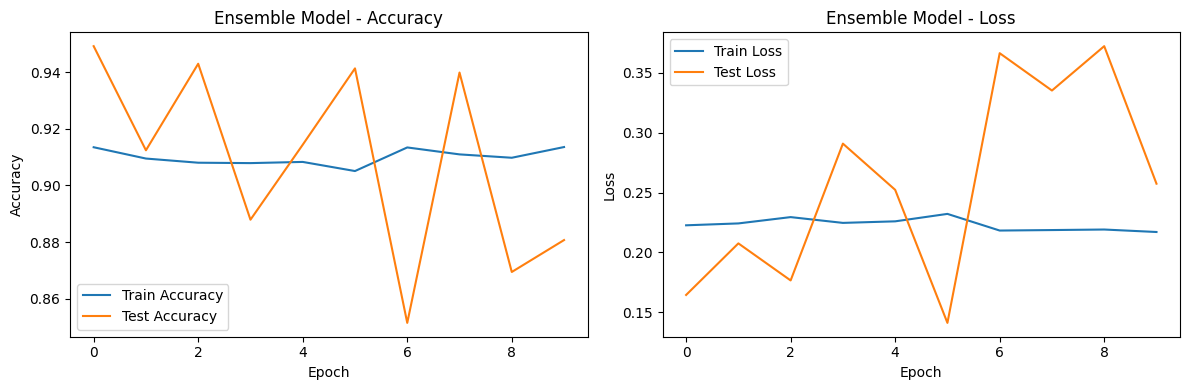

In [29]:
# Compile and train the ensemble model
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model, ensemble_history = train_model(ensemble_model, "Ensemble Model")

# Plot accuracy and loss graphs for the ensemble model
plot_metrics(ensemble_history, "Ensemble Model")